# Librerías utilizadas:

In [67]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Importación de data set

In [68]:
data = pd.read_csv('c:\\Users\\Nico\\Desktop\\PyE/diabetes.csv')
data = data[(data['Insulin'] != 0) & (data['SkinThickness'] != 0) & (data['Glucose'] != 0)]
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1


In [69]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,3.292621,122.615776,70.646310,29.129771,155.885496,33.002036,0.526120,30.839695,0.330789
std,3.211645,30.822276,12.484668,10.507575,118.738199,7.214395,0.350386,10.199903,0.471097
min,0.000000,56.000000,24.000000,7.000000,14.000000,0.000000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,77.000000,28.400000,0.270000,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.000000,33.200000,0.452000,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Visualización de la distribución de variables
* Histograma de las distintas variables

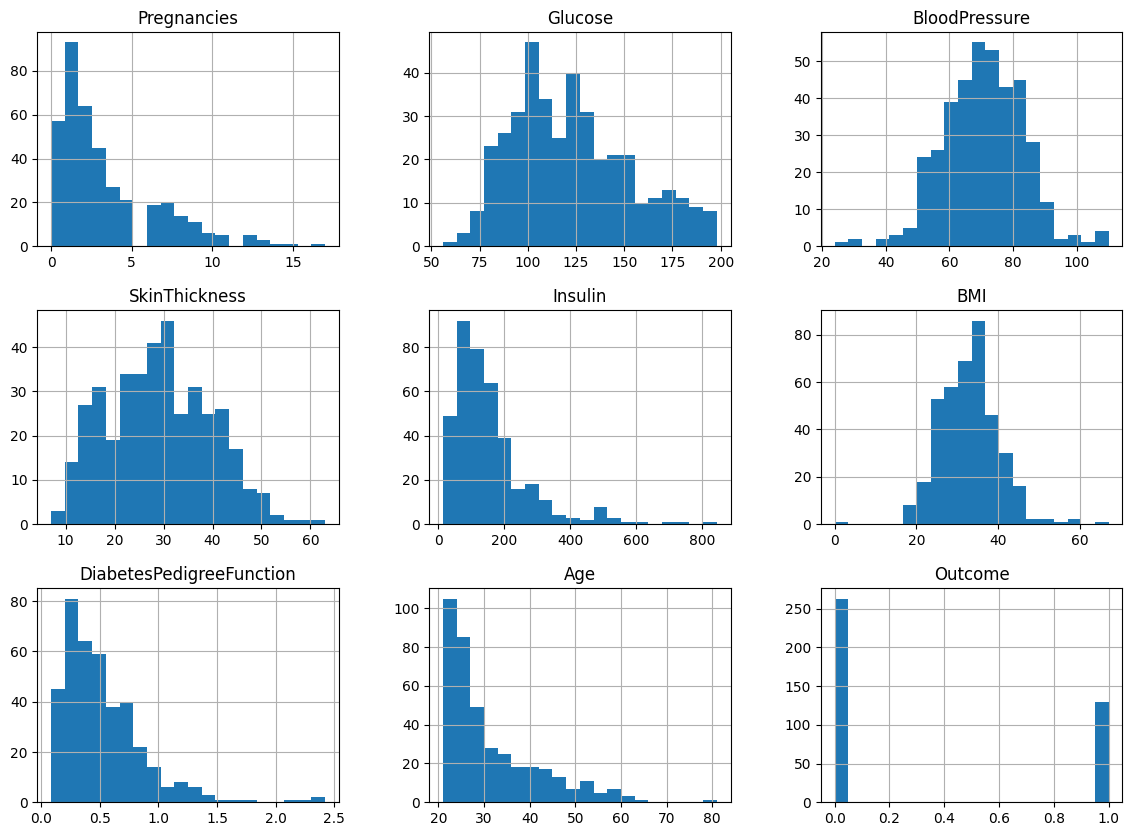

In [70]:
data.hist(bins=20, figsize=(14,10))
plt.show()

# Prueba T-Student

In [71]:
outcome_0 = data[data['Outcome'] == 0]
outcome_1 = data[data['Outcome'] == 1]

t_stat, p_val = stats.ttest_ind(outcome_0['Glucose'], outcome_1['Glucose'], equal_var=False)
print(f'T-statistic: {t_stat}, P-value: {p_val}')

T-statistic: -11.152889103682549, P-value: 3.767590913746811e-23


In [72]:
import numpy as np

mean_0 = np.mean(outcome_0['Glucose'])
mean_1 = np.mean(outcome_1['Glucose'])

std_0 = np.std(outcome_0['Glucose'], ddof=1)
std_1 = np.std(outcome_1['Glucose'], ddof=1)

n_0 = len(outcome_0['Glucose'])
n_1 = len(outcome_1['Glucose'])

t_stat_manual = (mean_0 - mean_1) / np.sqrt((std_0**2 / n_0) + (std_1**2 / n_1))

t_stat_manual

-11.152889103682549

In [73]:
numerator = ((std_0**2 / n_0) + (std_1**2 / n_1))**2
denominator = ((std_0**2 / n_0)**2 / (n_0 - 1)) + ((std_1**2 / n_1)**2 / (n_1 - 1))
df = numerator / denominator

p_value_manual = stats.t.cdf(t_stat_manual, df) * 2  

p_value_manual


3.767590913746865e-23

# Prueba Chi-Cuadrado


In [74]:
data['Glucose_Cat'] = pd.cut(data['Glucose'], bins=[0, 100, 150, data['Glucose'].max() + 1], labels=['<=100', '101-150', '>150'])

contingency_table_glucose = pd.crosstab(data['Glucose_Cat'], data['Outcome'])
chi2_glucose, p_glucose, dof_glucose, expected_glucose = stats.chi2_contingency(contingency_table_glucose)

print(contingency_table_glucose)
print(f"\nChi2: {chi2_glucose}, P-value: {p_glucose}\n")

Outcome        0   1
Glucose_Cat         
<=100        105  11
101-150      136  61
>150          22  58

Chi2: 85.73470672148675, P-value: 2.415154852443532e-19



In [75]:

observed = np.array([
    [191, 18],
    [271, 143],
    [35, 105]
])

row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
total = observed.sum()

expected = np.outer(row_totals, col_totals) / total

chi2_value = ((observed - expected) ** 2 / expected).sum()

dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)

p_value = 1 - stats.chi2.cdf(chi2_value, dof)

print(f"Frecuencias Observadas:\n{observed}\n")
print(f"Frecuencias Esperadas:\n{expected}\n")
print(f"Chi2: {chi2_value}")
print(f"P-value: {p_value}")
print(f"Grados de Libertad (dof): {dof}")

Frecuencias Observadas:
[[191  18]
 [271 143]
 [ 35 105]]

Frecuencias Esperadas:
[[136.13761468  72.86238532]
 [269.66972477 144.33027523]
 [ 91.19266055  48.80733945]]

Chi2: 162.7583125903085
P-value: 0.0
Grados de Libertad (dof): 2


# Regresión lineal

In [76]:
X = data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
          'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = data['Outcome']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     25.45
Date:                Sun, 28 Jul 2024   Prob (F-statistic):           1.74e-31
Time:                        20:22:43   Log-Likelihood:                -177.73
No. Observations:                 393   AIC:                             373.5
Df Residuals:                     384   BIC:                             409.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.1058      0.143     -7.759      0.000      -1.386      -0.826
Pregnancies                  0.0130      0.008      1.561      0.119      -0.003       0.029
Glucose                      0.0064      0.001      7.862      0.000       0.005       0.008
BloodPressure             2.939e-05      0.002      0.017      0.986      -0.003       0.003
SkinThickness                0.0016      0.002      0.644      0.520      -0.003       0.006
Insulin                     -0.0001      0.000     -0.603      0.547      -0.001       0.000
BMI                          0.0096      0.004      2.572      0.010       0.002       0.017
DiabetesPedigreeFunction     0.1550      0.057      2.726      0.007       0.043       0.267
Age                          0.0059      0.003      2.122      0.035       0.000       0.011
==============================================================================
Omnibus:                        9.492   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.399
Skew:                           0.345   Prob(JB):                      0.00910
Kurtosis:                       2.687   Cond. No.                     1.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Boxplot de Glucosa por Outcome

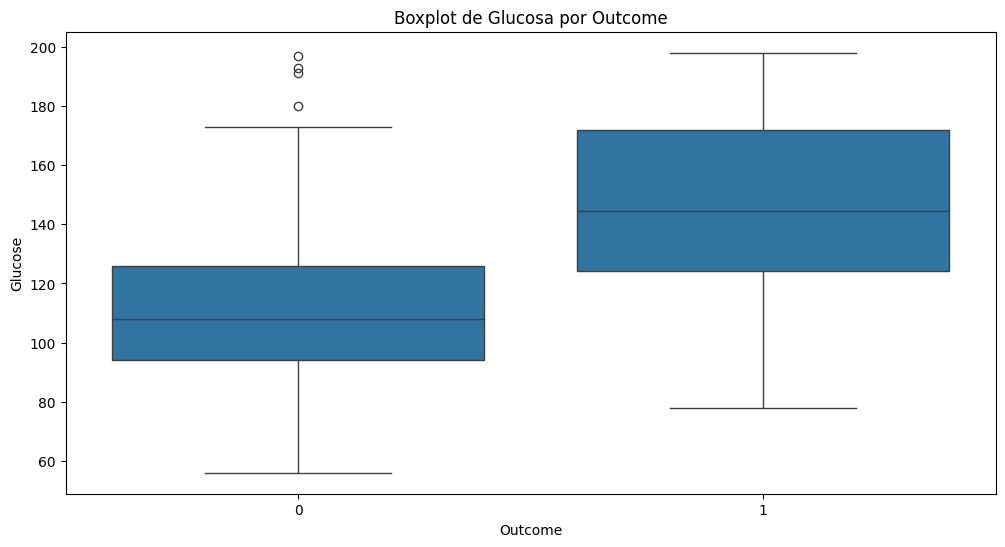

In [77]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Outcome', y='Glucose', data=data)
plt.title('Boxplot de Glucosa por Outcome')
plt.show()